In [9]:
import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"



In [2]:
NYdata = pd.read_csv('AB_NYC_2019.csv')

In [3]:
NYdata.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
NYdata.shape

(48895, 16)

In [5]:
NYdata.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [6]:
NYdata['last_review'] = pd.to_datetime(NYdata['last_review'],infer_datetime_format=True)

In [13]:

NYdata.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can see that the columns last_review,reviews_per_month,name and host_id having missing values 

In [14]:
NYdata=NYdata.drop(['host_name','name'], axis=1)

Dropping the columns host_name and name since they are not useful

In [15]:
NYdata[NYdata['number_of_reviews']== 0.0].shape

(10052, 14)

We observe that NaN values in the columns last_review and reviews_per_month occur for observations where there were no reviews were given

In [17]:
NYdata['reviews_per_month'] = NYdata['reviews_per_month'].replace(np.nan, 0)

In [18]:
earliest = min(NYdata['last_review'])
NYdata['last_review'] = NYdata['last_review'].replace(np.nan, earliest)
NYdata['last_review'] = NYdata['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

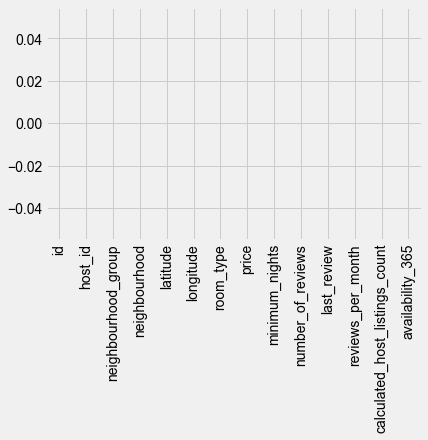

In [20]:
NYdata.isnull().sum().plot(kind = 'bar')

We can see that there are no Null values in the dataset

####Tageting our dependent variable is the "Price" variable in the dataset which needs to be predicted after the customer
have entered their details

We notice that our response variable "price" is highly skewed which can cause problems for machine learning alogorithms. Hence
implementing log transformation and eliminating the outliers

Text(0.5, 0, 'log(1+price)')

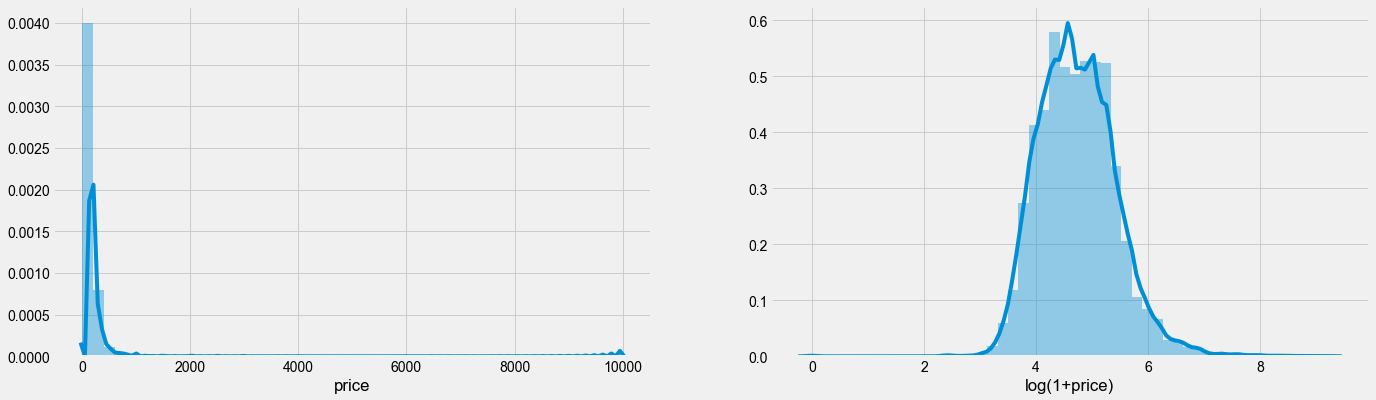

In [21]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(NYdata['price'], ax=axes[0])
sns.distplot(np.log1p(NYdata['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')


In [16]:
NYdata = NYdata[np.log1p(NYdata['price']) < 8]
NYdata = NYdata[np.log1p(NYdata['price']) > 3]

Text(0.5, 0, 'log(1+price)')

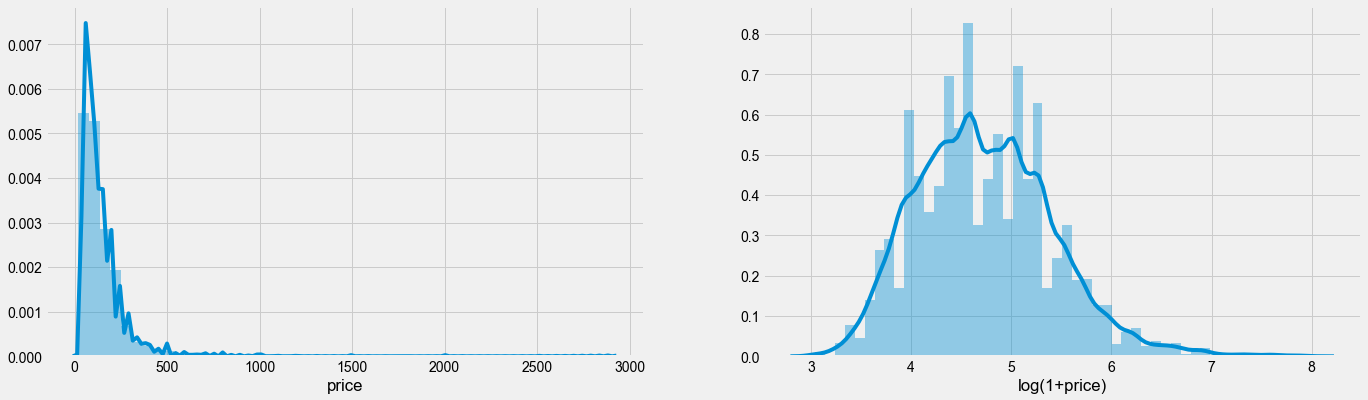

In [18]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(NYdata['price'], ax=axes[0])
sns.distplot(np.log1p(NYdata['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

In [19]:
NYdata['price'] = np.log1p(NYdata['price'])

In [20]:
NYdata = NYdata.drop(['host_id', 'id'], axis=1)

In [21]:
NYdata.shape

(48784, 12)

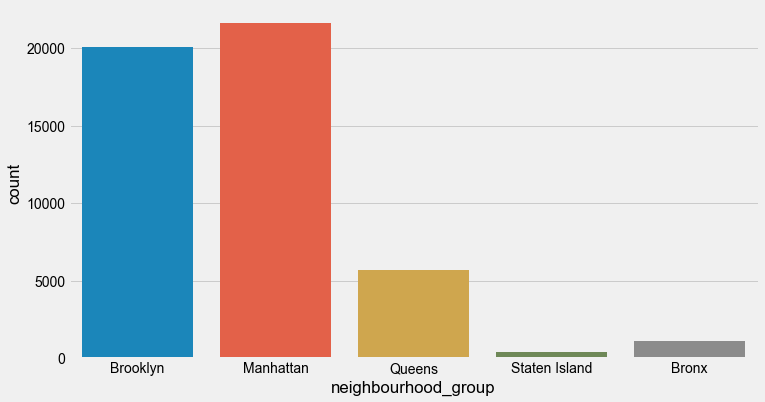

In [22]:
sns.catplot(x='neighbourhood_group', kind='count' ,data=NYdata)
fig = plt.gcf()
fig.set_size_inches(12, 6)

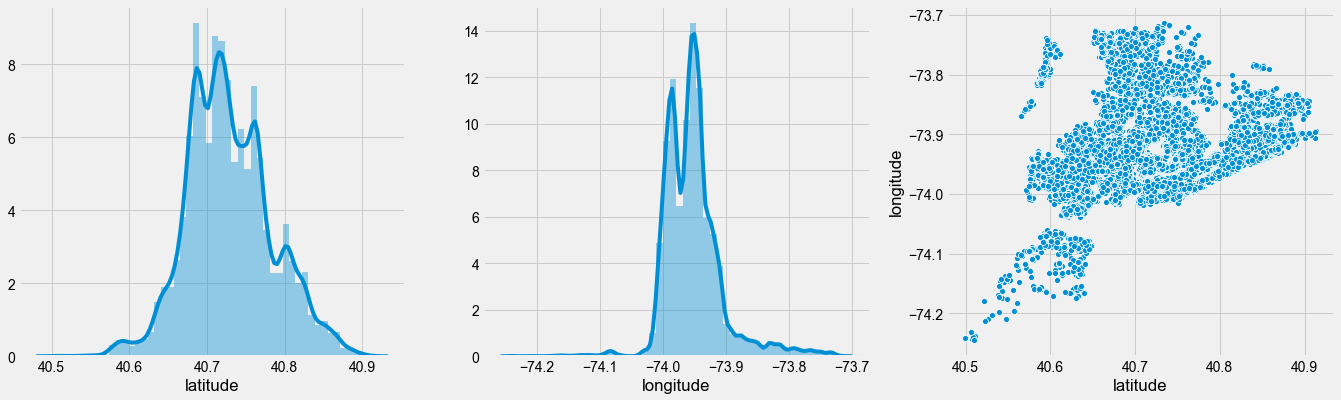

In [23]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(NYdata['latitude'], ax=axes[0])
sns.distplot(NYdata['longitude'], ax=axes[1])
sns.scatterplot(x= NYdata['latitude'], y=NYdata['longitude'])

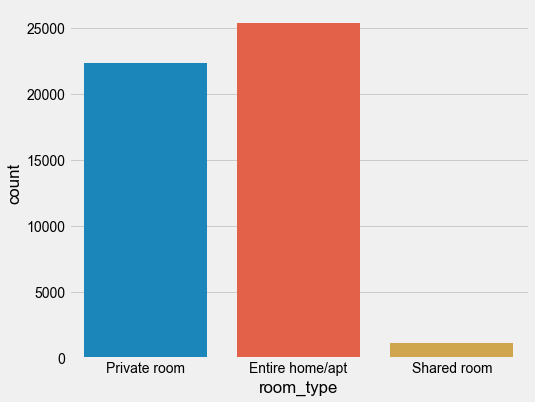

In [24]:
sns.catplot(x='room_type', kind='count' ,data=NYdata)
fig = plt.gcf()
fig.set_size_inches(8, 6)

Text(0, 0.5, 'count')

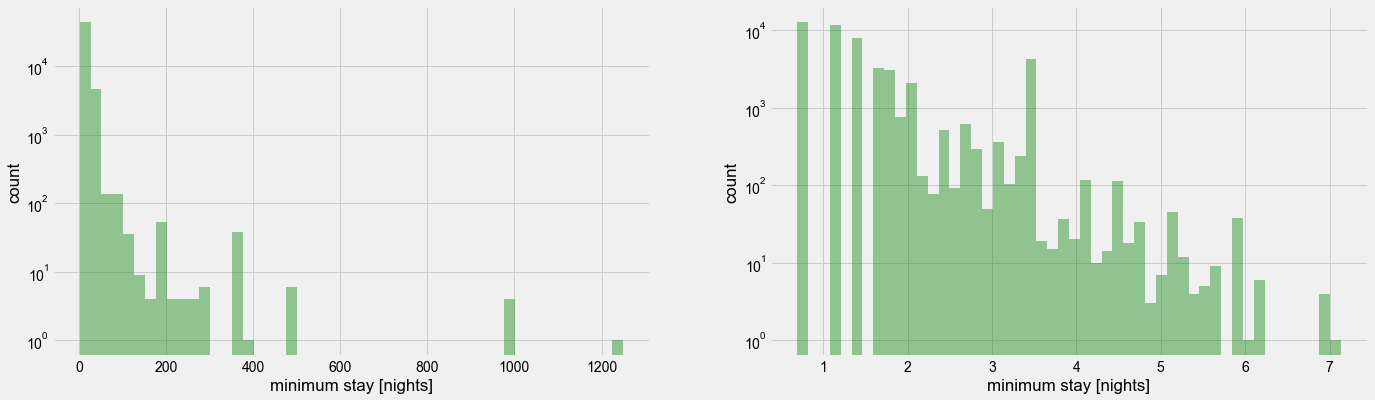

In [25]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(NYdata['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(NYdata['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [26]:
NYdata['minimum_nights'] = np.log1p(NYdata['minimum_nights'])

Text(0.5, 0, 'ln(reviews_per_month)')

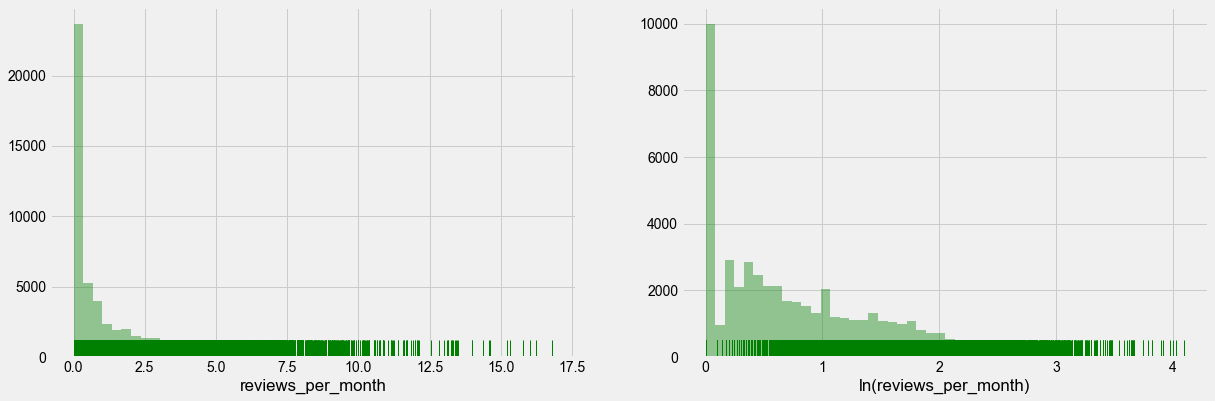

In [27]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(NYdata[NYdata['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(NYdata[NYdata['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

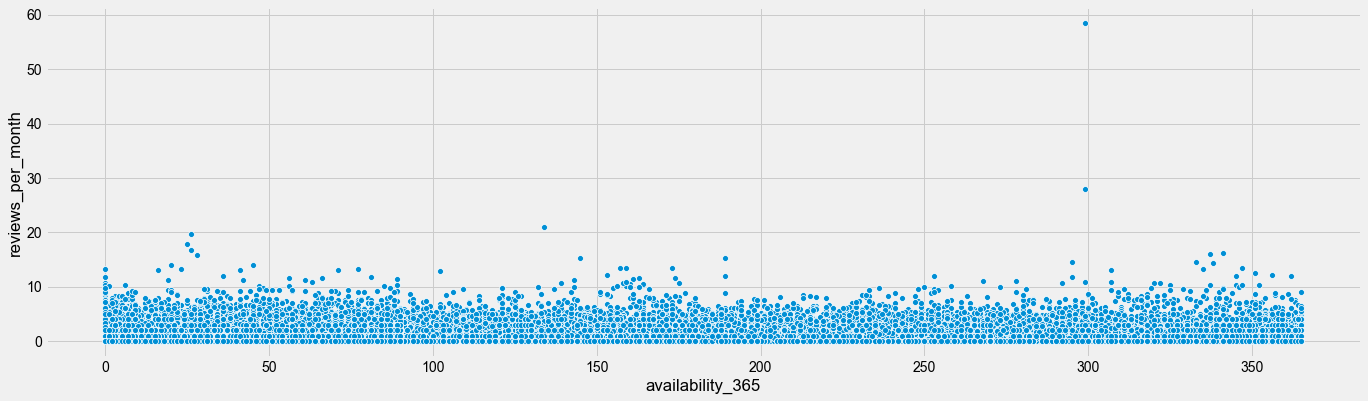

In [28]:
fig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x= NYdata['availability_365'], y=NYdata['reviews_per_month'])

In [29]:
NYdata['reviews_per_month'] = NYdata[NYdata['reviews_per_month'] < 17.5]['reviews_per_month']

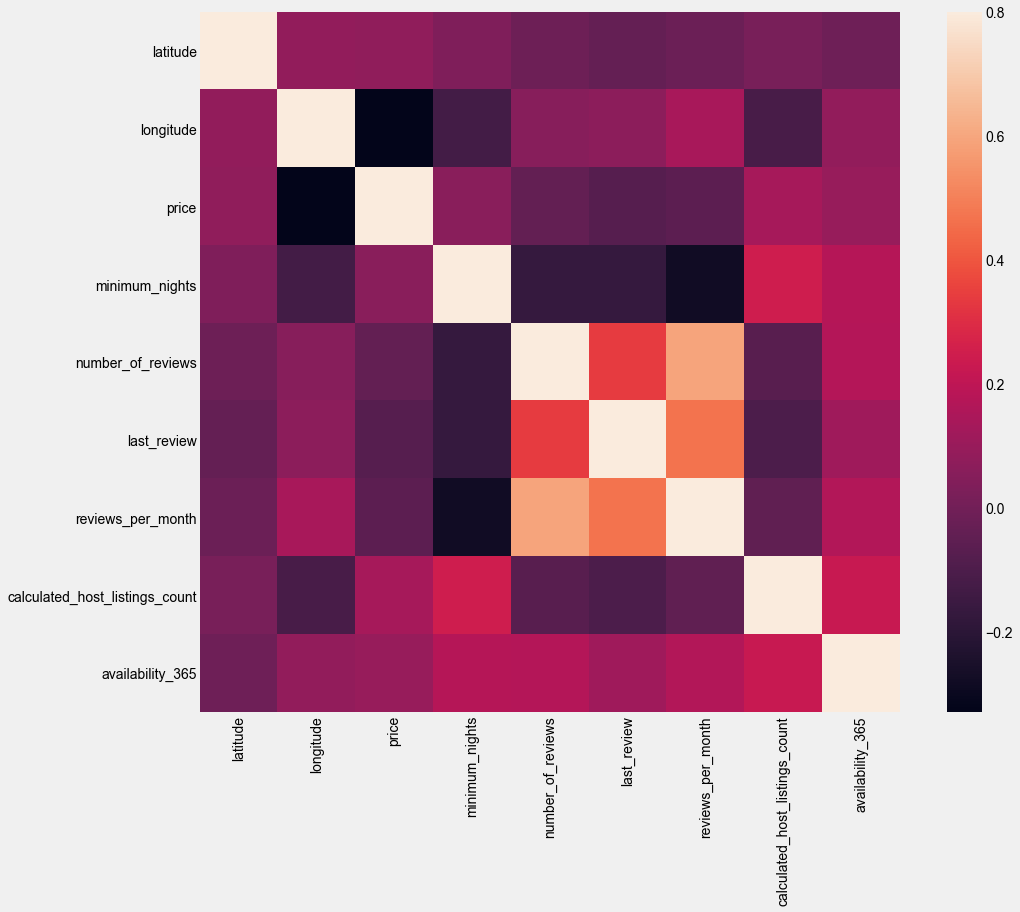

In [30]:
corrmatrix = NYdata.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

In [31]:
categorical_features = NYdata.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48784, 3)


In [32]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
NYdata['reviews_per_month'] = NYdata['reviews_per_month'].fillna(0)

In [34]:
numerical_features =  NYdata.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)

In [35]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [36]:
Processed_data = pd.concat([X_df, y], axis = 1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [39]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [40]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [41]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

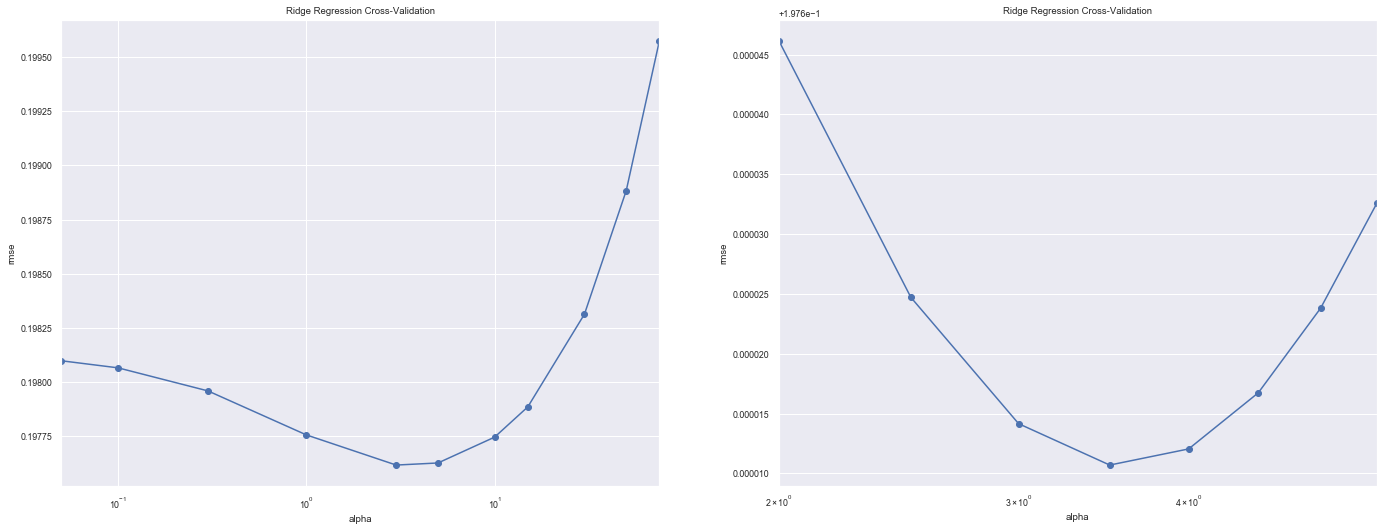

In [42]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')

In [43]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.197611,0.006703,0.194779,0.0,0.576172,0.565842


In [44]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

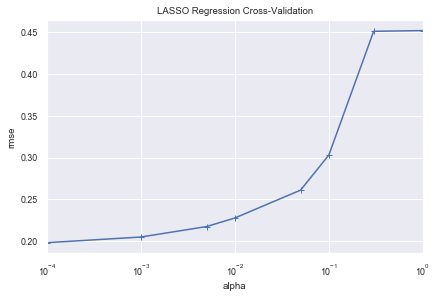

In [45]:
cv_lasso = pd.Series(cv_lasso, index = alphas) 
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-+') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [46]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,LASSO Regression,0.198298,0.006739,0.196536,0.198545,0.57235,0.56578


In [47]:
features = list(categorical_features_one_hot.columns) + list(numerical_features.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 107 variables and eliminated the other 130 variables


In [48]:
coef

neighbourhood_group_Bronx                  -0.024668
neighbourhood_group_Brooklyn               -0.084004
neighbourhood_group_Manhattan              -0.123639
neighbourhood_group_Queens                 -0.011814
neighbourhood_group_Staten Island          -0.048682
neighbourhood_Allerton                     -0.009892
neighbourhood_Arden Heights                -0.000202
neighbourhood_Arrochar                      0.200802
neighbourhood_Arverne                      -0.018857
neighbourhood_Astoria                      -0.000000
neighbourhood_Bath Beach                    0.424034
neighbourhood_Battery Park City             0.126793
neighbourhood_Bay Ridge                    -0.479505
neighbourhood_Bay Terrace                   0.000000
neighbourhood_Bay Terrace, Staten Island   -0.000000
neighbourhood_Baychester                   -0.000000
neighbourhood_Bayside                       0.188825
neighbourhood_Bayswater                    -0.006058
neighbourhood_Bedford-Stuyvesant           -0.

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

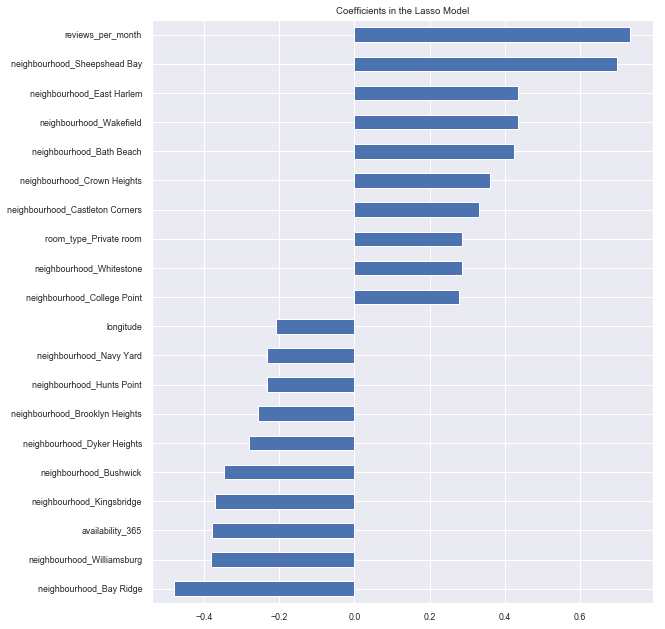

In [49]:
imp_coef = pd.concat([coef.sort_values().iloc[:10],
                     coef.sort_values().iloc[-10:]])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [50]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
#cv_huber = [-rmse_cv(HuberRegressor(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]
cv_huber = [0.20051906841425277, 0.20044833042114646, 0.20048899799050565, 0.200533996471012, 0.20051788009059482, 0.2005294886778608, 0.20052011204607623, 0.2004070661477452]

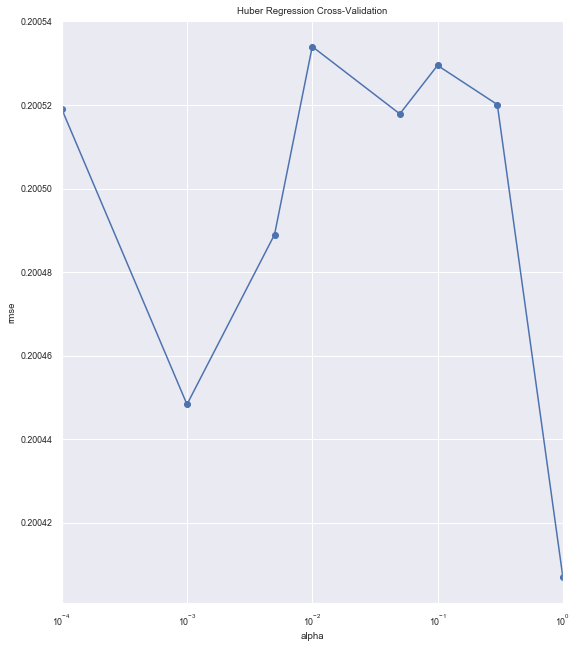

In [51]:
cv_huber = pd.Series(cv_huber, index = alphas) 
cv_huber.plot(title = "Huber Regression Cross-Validation", style='-o') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [52]:
best_alpha = alphas[np.argmin(cv_huber.values)]
huber_CV_best = -rmse_cv(HuberRegressor(alpha=best_alpha))
huber = HuberRegressor(alpha=best_alpha)
huber.fit(X_train, y_train) 
y_train_huber = huber.predict(X_train)
y_test_huber = huber.predict(X_test)
huber_results = pd.DataFrame({'algorithm':['Huber Regression'],
            'CV error': huber_CV_best.mean(), 
            'CV std': huber_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_huber)],
            'test error': [mean_squared_error(y_test, y_test_huber)],
            'training_r2_score': [r2_score(y_train, y_train_huber)],
            'test_r2_score': [r2_score(y_test, y_test_huber)]})
huber_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Huber Regression,0.209549,0.009486,0.211888,0.212353,0.538943,0.535581


In [53]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

In [54]:
rfr_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Random Forest Regressor [baseline],0.193149,0.00515,0.033798,0.20003


In [55]:
rfr_baseline.estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1608637542, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1273642419, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1935803228, splitter='best'),
 DecisionTreeRegres

In [56]:
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [57]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [58]:
#best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.174032,0.006244,0.075947,0.175403,0.834744,0.61639


In [59]:
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_xgb_base, y_train)]})

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:38:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:42:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:45:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:49:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:52:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:56:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [60]:
print(xgb_baseline)
xgb_baseline_results

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


,algorithm,CV error,CV std,training error
0,XGBRegressor[baseline],-0.177748,0.005752,0.164874


In [61]:
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=5, min_child_weight=1 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:03:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:08:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:12:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:18:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:23:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:28:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.173099,0.004799,0.117471,0.182283,0.744389,0.601344


In [63]:
pd.concat([ridge_results, lasso_results,huber_results, rfr_best_results, xgb_best_results], axis=0, ignore_index=True)

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.197611,0.006703,0.194779,0.000000,0.576172,0.565842
1,LASSO Regression,0.198298,0.006739,0.196536,0.198545,0.572350,0.565780
2,Huber Regression,0.209549,0.009486,0.211888,0.212353,0.538943,0.535581
3,Random Forest Regressor,0.174032,0.006244,0.075947,0.175403,0.834744,0.616390
4,XGBRegressor,0.173099,0.004799,0.117471,0.182283,0.744389,0.601344
